This notebook makes the exchange in asp vs. non-asp figure.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

In [2]:
fexchange = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
exchange = pd.read_csv(fexchange, sep='\t')
exchange.head()

,otu,prevalence_exchange,meta_var,meta_val,site_comparison,n_patients
0,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,0.215909,all_patients,all_patients,bal-gastric_fluid,88
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.284091,all_patients,all_patients,bal-gastric_fluid,88
2,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.431818,all_patients,all_patients,bal-gastric_fluid,88
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.227273,all_patients,all_patients,bal-gastric_fluid,88
4,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.227273,all_patients,all_patients,bal-gastric_fluid,88


## Slopegraph

In [3]:
def make_plot(jitter=True, add_boxplot=False):
    asp = 'Aspiration/Penetration'
    nml = 'Normal'
    sitecomps = ['bal-throat_swab', 'bal-gastric_fluid', 'gastric_fluid-throat_swab']

    asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}

    fig, ax = plt.subplots(figsize=(7, 4))

    i = 1.0
    for_boxplot = []
    positions = []
    for s in sitecomps:
        
        n = exchange.query('site_comparison == @s').query('meta_val == @nml')['prevalence_exchange'].values
        a = exchange.query('site_comparison == @s').query('meta_val == @asp')['prevalence_exchange'].values

        # Track values for one call to boxplot after the loop
        # Add the normal values first
        for_boxplot.append(n)
        # and aspiration values next
        for_boxplot.append(a)

        # Set up color: pink for higher in asp, brown for higher in normal
        c = (a - n) > 0
        c = [asp_colors[asp] if j else asp_colors[nml] for j in c]

        # And set up alpha values for the lines (brown should be more transparent)
        alphas = [0.8 if j == asp_colors[asp] else 0.6 for j in c]

        x1 = i - 0.2
        x2 = i + 0.2

        # Also track positions for boxplot
        positions += [x1, x2]

        # Plot the lines connecting the dots
        for ni, ai, ci, alphai in zip(n, a, c, alphas):
            ax.plot([x1, x2], [ni, ai], c=ci, alpha=alphai)

        ## With "jitter"
        if jitter:
            # Set up some noise for jitter
            noise = np.random.normal(loc=0, scale=0.015, size=len(n))

            ax.scatter(len(n)*[x1-0.01]+noise, n, c=asp_colors[nml], 
                       s=25, label='Normal', 
                       linewidths=0.25, edgecolor='k')
            ax.scatter(len(a)*[x2+0.01]+noise, a, c=asp_colors[asp], 
                       s=25, label='Aspiration/Penetration', 
                       linewidths=0.25, edgecolor='k')
        ## Without
        else:
            ax.scatter(len(n)*[x1-0.01], n, c=asp_colors[nml], 
                       s=25, label='Normal', 
                       linewidths=0.25, edgecolor='k')
            ax.scatter(len(a)*[x2+0.01], a, c=asp_colors[asp],
                       s=25, label='Aspiration/Penetration', 
                       linewidths=0.25, edgecolor='k')

        i += 1.0

    # Overlay boxplot
    boxprops = {'linewidth': 0.75, 'color': 'k'}
    lineprops = {'linewidth': 0.75, 'color': 'k', 'linestyle': '-'}

    boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                           'whiskerprops': lineprops, 'capprops': lineprops})
    if add_boxplot:
        bp = ax.boxplot(for_boxplot, positions=positions, 
                        widths=0.25, showcaps=False, whis=0,
                        **boxplot_kwargs)

        # Edit colors
        if False:
            for _, part in bp.items():
                # I'm hoping every other element is color
                i = 0
                for elem in part:
                    if i % 2 == 1:
                        elem.set_color(asp_colors[asp])
                    else:
                        elem.set_color(asp_colors[nml])
                    i += 1

    # Axes and labels
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Lung and\noropharyngeal swab', 
                        'Lung and\ngastric fluid', 
                        'Gastric fluid and\noropharyngeal swab'],
                       fontsize='x-large')
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['0', '50', '100%'], fontsize='x-large')
    ax.set_ylabel('Prevalence of exchange', fontsize='x-large')
    
    txt = ax.text(-0.11, 1.025, 'B', transform=ax.transAxes, fontsize=24)
    
    ## P value indicators
    ax.text(0.86, 0.9, '***', fontsize=30)
    #ax.text(1.95, 0.9, '*', fontsize=30)
    
    # Fix legend to show only the first two elements
    plot_legend = True
    if plot_legend:
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles[0:2], labels[0:2], 
                      #loc=(-0.01, 0.82),  
                      fontsize='large',
                      handletextpad=0.01,
                      loc='upper center', 
                      bbox_to_anchor=(0.5, 1.15), 
                      ncol=2)
        lgd.legendHandles[0]._sizes = [80]
        lgd.legendHandles[1]._sizes = [80]
        
        # Align text with marker
        #lgd.texts[0].set_va('center')
    
    return fig, ax

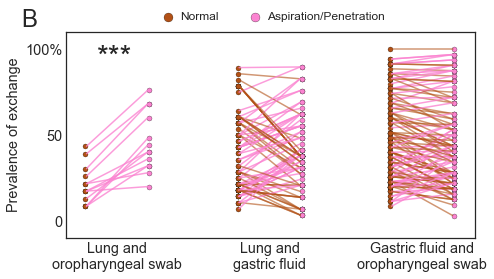

In [4]:
fig, ax = make_plot(jitter=False, add_boxplot=False)
fig.tight_layout()
fig.savefig('../../final/figures/figure4.asp_vs_nonasp_exchange.png', dpi=200)
fig.savefig('../../final/figures/figure4.asp_vs_nonasp_exchange.pdf', dpi=500)

## pvalues and sample sizes

In [5]:
## Calculate p-value

# Paired, non-parametric t-test
from scipy.stats import ttest_rel

sitecomps = ['bal-throat_swab', 'bal-gastric_fluid', 'gastric_fluid-throat_swab']
asp = 'Aspiration/Penetration'
nml = 'Normal'

for s in sitecomps:

    n = exchange.query('site_comparison == @s').query('meta_val == @nml')['prevalence_exchange']
    a = exchange.query('site_comparison == @s').query('meta_val == @asp')['prevalence_exchange']
    
    print(s, ttest_rel(np.log10(n), np.log10(a)))


('bal-throat_swab', Ttest_relResult(statistic=-6.253931433017956, pvalue=4.229405752935597e-05))
('bal-gastric_fluid', Ttest_relResult(statistic=0.5459443682469993, pvalue=0.5867244685594044))
('gastric_fluid-throat_swab', Ttest_relResult(statistic=1.5634220840429418, pvalue=0.12067742472912343))


Next, I'll show the summary statistics for prevalence calculations across all patients as well as split by aspiration status. Note here that the `count` column indicates how many OTUs these calculations were made for. The number of patients that were used in each calculation will be counted and tracked in the prevalence code itself (`src/analysis/prevalence_exchange.py`).

In [6]:
keepvars = ['mbs_consolidated', 'all_patients']
exchange.query('meta_var == @keepvars').groupby(['site_comparison', 'meta_var', 'meta_val']).describe()['prevalence_exchange']

count  \
site_comparison           meta_var         meta_val                        
bal-gastric_fluid         all_patients     all_patients             76.0   
                          mbs_consolidated Aspiration/Penetration   76.0   
                                           Normal                   76.0   
bal-throat_swab           all_patients     all_patients             13.0   
                          mbs_consolidated Aspiration/Penetration   13.0   
                                           Normal                   13.0   
gastric_fluid-throat_swab all_patients     all_patients            117.0   
                          mbs_consolidated Aspiration/Penetration  117.0   
                                           Normal                  117.0   

                                                                       mean  \
site_comparison           meta_var         meta_val                           
bal-gastric_fluid         all_patients     all_patients            0.408493   
                          mbs_consolidated Aspiration/Penetration  0.397459   
                                           Normal                  0.397556   
bal-throat_swab           all_patients     all_patients            0.320337   
                          mbs_consolidated Aspiration/Penetration  0.455385   
                                           Normal                  0.210702   
gastric_fluid-throat_swab all_patients     all_patients            0.479325   
                          mbs_consolidated Aspiration/Penetration  0.467415   
                                           Normal                  0.486691   

                                                                        std  \
site_comparison           meta_var         meta_val                           
bal-gastric_fluid         all_patients     all_patients            0.205845   
                          mbs_consolidated Aspiration/Penetration  0.220220   
                                           Normal                  0.225073   
bal-throat_swab           all_patients     all_patients            0.146852   
                          mbs_consolidated Aspiration/Penetration  0.174003   
                                           Normal                  0.112044   
gastric_fluid-throat_swab all_patients     all_patients            0.249044   
                          mbs_consolidated Aspiration/Penetration  0.253557   
                                           Normal                  0.247178   

                                                                        min  \
site_comparison           meta_var         meta_val                           
bal-gastric_fluid         all_patients     all_patients            0.113636   
                          mbs_consolidated Aspiration/Penetration  0.034483   
                                           Normal                  0.071429   
bal-throat_swab           all_patients     all_patients            0.191781   
                          mbs_consolidated Aspiration/Penetration  0.200000   
                                           Normal                  0.086957   
gastric_fluid-throat_swab all_patients     all_patients            0.135135   
                          mbs_consolidated Aspiration/Penetration  0.031250   
                                           Normal                  0.085714   

                                                                        25%  \
site_comparison           meta_var         meta_val                           
bal-gastric_fluid         all_patients     all_patients            0.215909   
                          mbs_consolidated Aspiration/Penetration  0.232759   
                                           Normal                  0.205357   
bal-throat_swab           all_patients     all_patients            0.232877   
                          mbs_consolidated Aspiration/Penetration  0.320000   
                                           Normal                  

Note: the patients are tracked in the code that calculates the exchange, `prevalence_exchange.py`.

# Unused plots

## Plot the differences

This plot shows the difference in prevalence for each exchanged OTU. The points are an exchanged OTU, the x-axis is the differential prevalence.

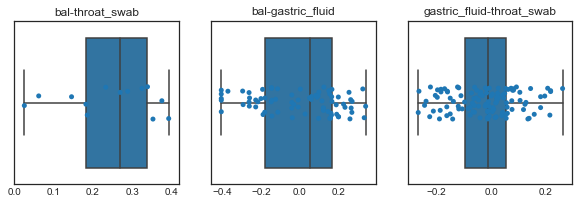

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

i = 0
for s in sitecomps:
    x = exchange.query('site_comparison == @s').query('meta_val == @nml')['prevalence_exchange'].values
    y = exchange.query('site_comparison == @s').query('meta_val == @asp')['prevalence_exchange'].values
    
    dif = y - x
    
    sns.boxplot(dif, ax=ax[i])
    sns.stripplot(dif, ax=ax[i], jitter=True)

    ax[i].set_title(s)
    i += 1

(<Figure size 504x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23c3ec90>)

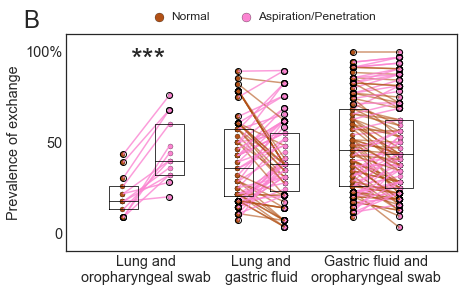

In [8]:
make_plot(jitter=False, add_boxplot=True)

/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


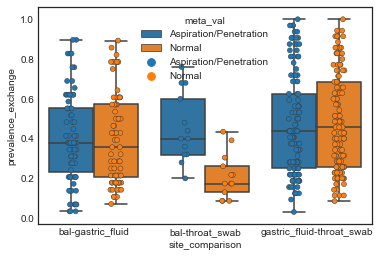

In [9]:
meta_var = 'mbs_consolidated'
sns.boxplot(data=exchange.query('meta_var == @meta_var'), 
            x='site_comparison', y='prevalence_exchange',
            hue='meta_val')
sns.stripplot(data=exchange.query('meta_var == @meta_var'), 
            x='site_comparison', y='prevalence_exchange',
            hue='meta_val', jitter=True, linewidth=0.5, split=True)

## Scatterplot version

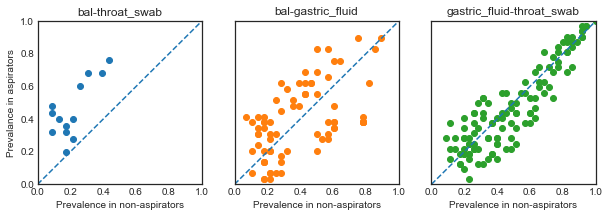

In [10]:
sns.set_style('white')
fig, ax = plt.subplots(1, 3, figsize=(10,3))

asp = 'Aspiration/Penetration'
nml = 'Normal'
sitecomps = ['bal-throat_swab', 'bal-gastric_fluid', 'gastric_fluid-throat_swab']
i = 0
for s in sitecomps:
    x = exchange.query('site_comparison == @s').query('meta_val == @nml')['prevalence_exchange']
    y = exchange.query('site_comparison == @s').query('meta_val == @asp')['prevalence_exchange']
    ax[i].scatter(x, y, c=sns.color_palette()[i])
    ax[i].plot([0, 1], [0, 1], '--')
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])
    
    if i > 0:
        ax[i].set_yticklabels('')
    else:
        ax[i].set_ylabel('Prevalance in aspirators')
    ax[i].set_xlabel('Prevalence in non-aspirators')
    ax[i].set_title(s)
    i += 1